In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [4]:
df = pd.read_csv('titanic-dataset.csv', usecols=['Age', 'Fare', 'Survived'])

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(714, 3)

In [7]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [8]:
X = df.iloc[:, 1:] 
y = df.iloc[:, 0]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


In [11]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred)

0.6223776223776224

In [13]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

np.float64(0.6317097026604068)

# Binning(Discretization | Quantile Binning | KMeans Binning)

In [32]:
kbin_age = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile',quantile_method='linear')
kbin_fare = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile',quantile_method='linear')

In [33]:
trf = ColumnTransformer([
    ('first', kbin_age, [0]),
    ('second', kbin_fare, [1])
])

In [34]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [35]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=15, quantile_method='linear'),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=15, quantile_method='linear')}

In [36]:
trf.named_transformers_['first']

,"n_bins n_bins: int or array-like of shape (n_features,), default=5The number of bins to produce. Raises ValueError if ``n_bins < 2``.",15
,"encode encode: {'onehot', 'onehot-dense', 'ordinal'}, default='onehot'Method used to encode the transformed result.- 'onehot': Encode the transformed result with one-hot encoding and return a sparse matrix. Ignored features are always stacked to the right.- 'onehot-dense': Encode the transformed result with one-hot encoding and return a dense array. Ignored features are always stacked to the right.- 'ordinal': Return the bin identifier encoded as an integer value.",'ordinal'
,"strategy strategy: {'uniform', 'quantile', 'kmeans'}, default='quantile'Strategy used to define the widths of the bins.- 'uniform': All bins in each feature have identical widths.- 'quantile': All bins in each feature have the same number of points.- 'kmeans': Values in each bin have the same nearest center of a 1D k-means cluster.For an example of the different strategies see::ref:`sphx_glr_auto_examples_preprocessing_plot_discretization_strategies.py`.",'quantile'
,"quantile_method quantile_method: {""inverted_cdf"", ""averaged_inverted_cdf"",""closest_observation"", ""interpolated_inverted_cdf"", ""hazen"",""weibull"", ""linear"", ""median_unbiased"", ""normal_unbiased""},default=""linear""Method to pass on to np.percentile calculation when usingstrategy=""quantile"". Only `averaged_inverted_cdf` and `inverted_cdf`support the use of `sample_weight != None` when subsampling is notactive... versionadded:: 1.7",'linear'
,"dtype dtype: {np.float32, np.float64}, default=NoneThe desired data-type for the output. If None, output dtype isconsistent with input dtype. Only np.float32 and np.float64 aresupported... versionadded:: 0.24",None
,"subsample subsample: int or None, default=200_000Maximum number of samples, used to fit the model, for computationalefficiency.`subsample=None` means that all the training samples are used whencomputing the quantiles that determine the binning thresholds.Since quantile computation relies on sorting each column of `X` andthat sorting has an `n log(n)` time complexity,it is recommended to use subsampling on datasets with avery large number of samples... versionchanged:: 1.3 The default value of `subsample` changed from `None` to `200_000` when `strategy=""quantile""`... versionchanged:: 1.5 The default value of `subsample` changed from `None` to `200_000` when `strategy=""uniform""` or `strategy=""kmeans""`.",200000
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for subsampling.Pass an int for reproducible results across multiple function calls.See the `subsample` parameter for more details.See :term:`Glossary `... versionadded:: 1.1",None


In [37]:
trf.named_transformers_['first'].n_bins_

array([15])

In [38]:
trf.named_transformers_['second'].n_bins_

array([15])

In [39]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [40]:
trf.named_transformers_['second'].n_bins_

array([15])

In [41]:
output = pd.DataFrame({
    'age': X_train['Age'],
    'age_trf': X_train_trf[:, 0],
    'fare': X_train['Fare'],
    'fare_trf': X_train_trf[:, 1]
})

In [42]:
output['age_labels'] = pd.cut(
    x=X_train['Age'],
    bins=trf.named_transformers_['first'].bin_edges_[0].tolist()
)
output['fare_labels'] = pd.cut(
    x=X_train['Fare'],
    bins=trf.named_transformers_['second'].bin_edges_[0].tolist()
)

In [43]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
588,22.0,4.0,8.0500,3.0,"(21.0, 23.0]","(7.896, 8.158]"
134,25.0,6.0,13.0000,6.0,"(23.0, 25.0]","(10.5, 13.0]"
882,22.0,4.0,10.5167,5.0,"(21.0, 23.0]","(10.5, 13.0]"
135,23.0,5.0,15.0458,7.0,"(21.0, 23.0]","(14.454, 18.75]"
867,31.0,8.0,50.4958,11.0,"(30.0, 32.0]","(31.275, 51.479]"


In [44]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf, y_train)
y_pred2 = clf.predict(X_test_trf)

In [45]:
accuracy_score(y_test, y_pred2)

0.6363636363636364

In [46]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy'))

np.float64(0.6303012519561815)

In [56]:
def discretize(bins, strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy,quantile_method='linear')
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy,quantile_method='linear')

    trf = ColumnTransformer([
        ('first', kbin_age, [0]),   # Age
        ('second', kbin_fare, [1])  # Fare
    ])

    X_trf = trf.fit_transform(X)

    print(np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy')))

    # Plot Age before/after
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Age Before")

    plt.subplot(122)
    plt.hist(X_trf[:, 0], color='red')
    plt.title("Age After")
    plt.show()

    # Plot Fare before/after
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Fare Before")

    plt.subplot(122)
    plt.hist(X_trf[:, 1], color='red')
    plt.title("Fare After")
    plt.show()

0.6386932707355242


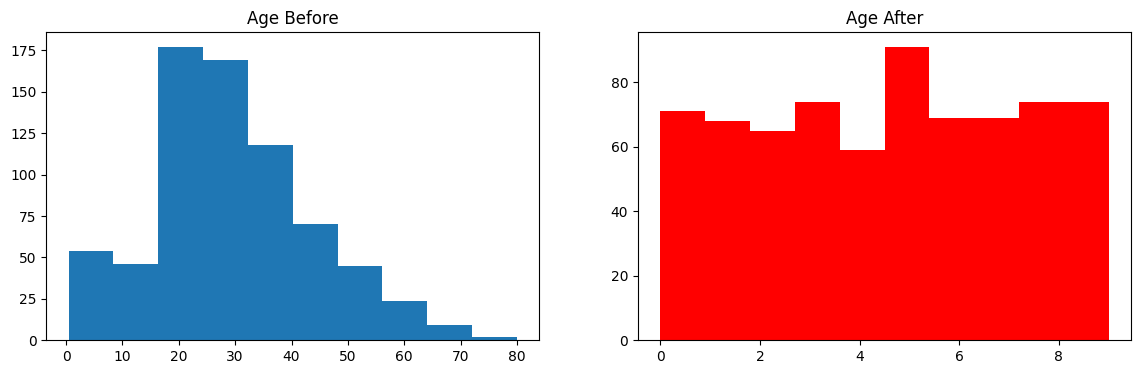

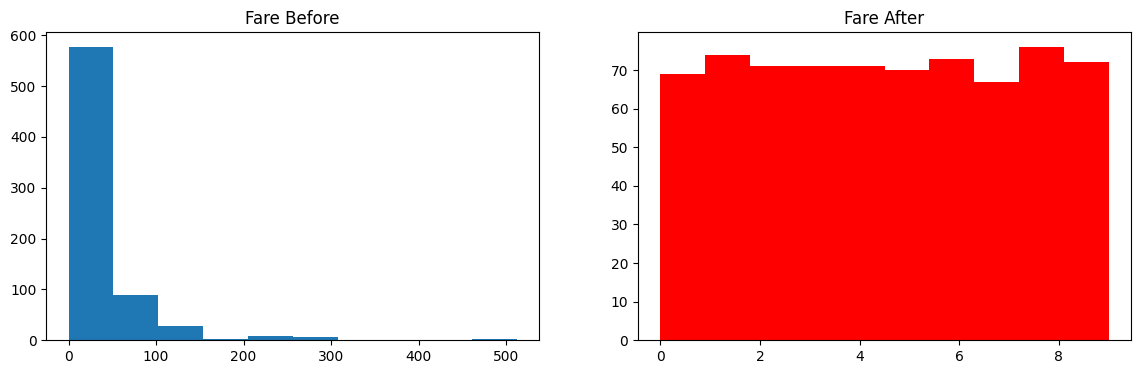

In [57]:
discretize(10,'quantile')

0.6289514866979656


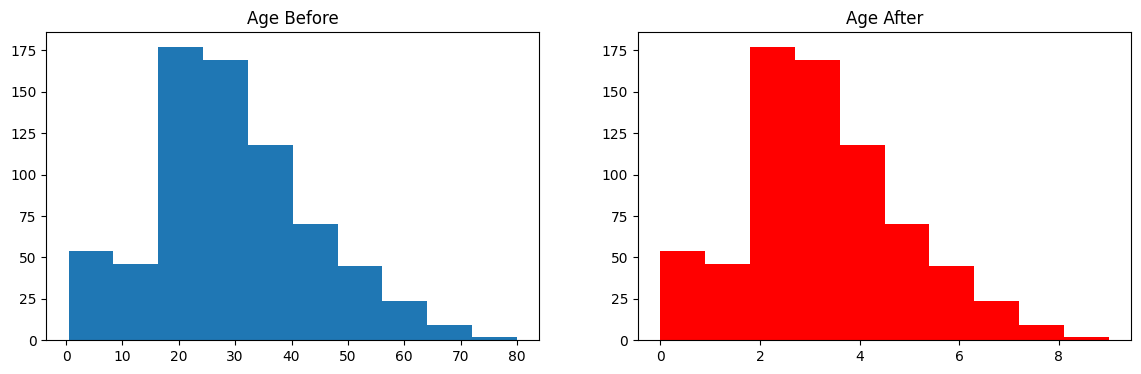

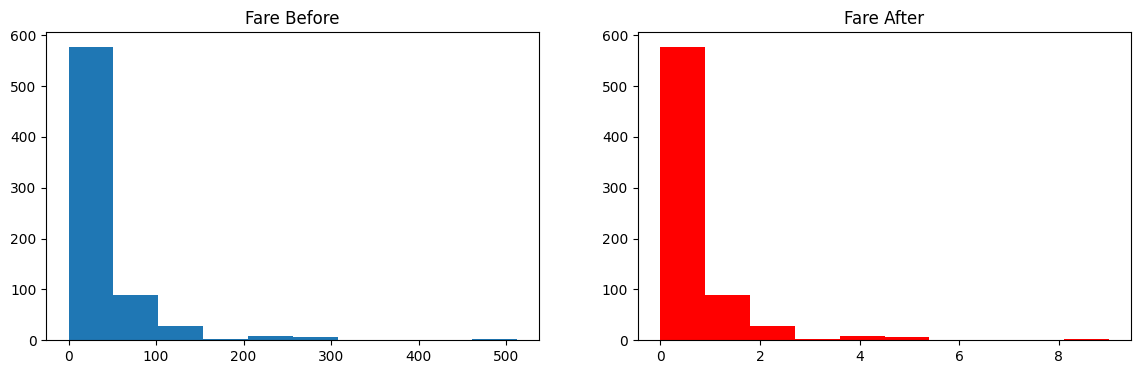

In [58]:
discretize(10,'uniform')

0.6344874804381847


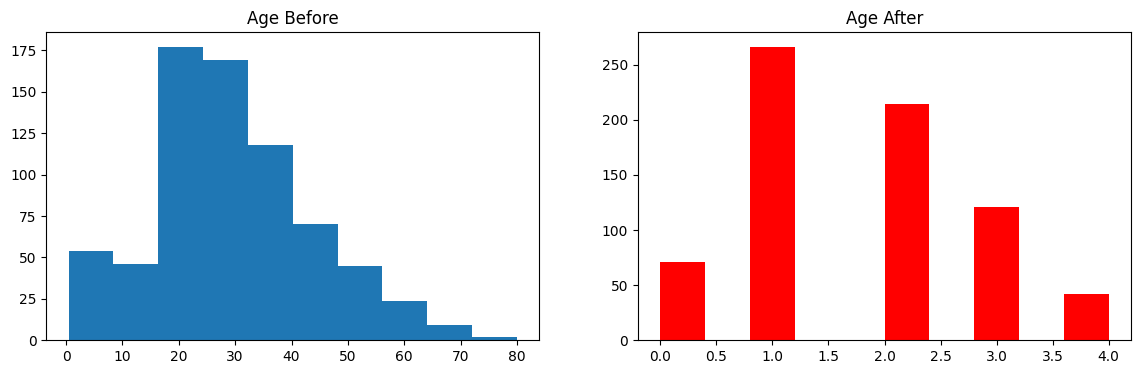

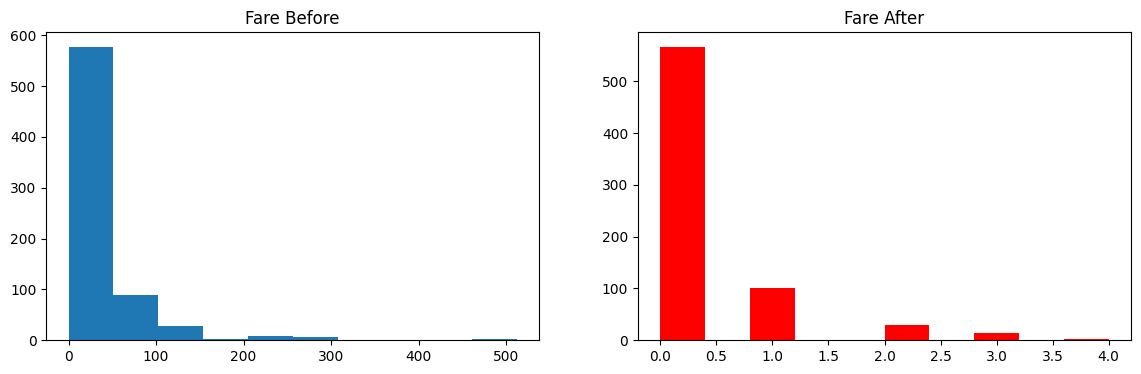

In [60]:
discretize(5,'kmeans')

# Binarization

In [61]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

In [62]:
df1 = pd.read_csv('titanic-dataset.csv')[['Age', 'Fare', 'SibSp', 'Parch', 'Survived']]

In [63]:
df1.dropna(inplace=True)
df1.head()

,Age,Fare,SibSp,Parch,Survived
0,22.0,7.2500,1,0,0
1,38.0,71.2833,1,0,1
2,26.0,7.9250,0,0,1
3,35.0,53.1000,1,0,1
4,35.0,8.0500,0,0,0


In [64]:
df1['Family']=df1['SibSp']+df1['Parch']

In [65]:
df1.head()

,Age,Fare,SibSp,Parch,Survived,Family
0,22.0,7.2500,1,0,0,1
1,38.0,71.2833,1,0,1,1
2,26.0,7.9250,0,0,1,0
3,35.0,53.1000,1,0,1,1
4,35.0,8.0500,0,0,0,0


In [67]:
df1.drop(columns=['SibSp','Parch'],inplace=True)

In [68]:
df1.head()

,Age,Fare,Survived,Family
0,22.0,7.2500,0,1
1,38.0,71.2833,1,1
2,26.0,7.9250,1,0
3,35.0,53.1000,1,1
4,35.0,8.0500,0,0


In [69]:
X=df1.drop(columns=['Survived'])
y=df1['Survived']

In [70]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [71]:
X_train.head()

,Age,Fare,Family
328,31.0,20.5250,2
73,26.0,14.4542,1
253,30.0,16.1000,1
719,33.0,7.7750,0
666,25.0,13.0000,0


In [73]:
# without binarization
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6083916083916084

In [74]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

np.float64(0.6485524256651016)

In [77]:
# Applying Binarization
from sklearn.preprocessing import Binarizer

In [80]:
trf = ColumnTransformer([
    ('bin', Binarizer(copy=False), ['Family'])
], remainder='passthrough')

In [81]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [86]:
pd.DataFrame(X_train_trf,columns=['Family','Age','Fare'])

,Family,Age,Fare
0,1.0,31.0,20.5250
1,1.0,26.0,14.4542
2,1.0,30.0,16.1000
3,0.0,33.0,7.7750
4,0.0,25.0,13.0000
...,...,...,...
566,1.0,46.0,61.1750
567,0.0,25.0,13.0000
568,0.0,41.0,134.5000
569,1.0,33.0,20.5250


In [88]:
clf=DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2=clf.predict(X_test_trf)
accuracy_score(y_test,y_pred2)

0.6013986013986014

In [89]:
X_trf=trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X_trf,y,cv=10,scoring='accuracy'))

np.float64(0.6346048513302034)